In [1]:
import keras
import numpy as np
from tqdm import tqdm

Using TensorFlow backend.


### Данные:
Будем работать с датасетом [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). 

In [2]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

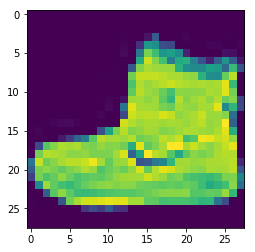

In [3]:
plt.imshow(X_train[0].reshape([28,28]))

### Задание:
Будем решать задачу классификации на 10 классов. Каждый класс соответствует одному из типов одежды. Исходная размерность признакового пространства: `784`, каждый пиксель является признаком. Будем снижать размерность признакового пространства с помощью метода главных компонент (`PCA`). Ваша задача оценить качество решенения задачи классификации по метрике `accuracy` в зависимости от числа главных компонент. Также оцените дисперсию функции качества в зависимости от числа главных компонент.

Нарисуйте график зависимости функции качества и ее дисперсии от числа главных компонент.

In [4]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [5]:
pca = PCA(n_components=3)
used_indices = np.random.choice(np.arange(X_train.shape[0]), 10000, replace=False)
X_train_lowdim = pca.fit_transform(X_train[used_indices].reshape([-1, 784]))
lr = LogisticRegression()
lr.fit(X_train_lowdim, y_train[used_indices])
accuracy_score(y_test, lr.predict(pca.transform(X_test.reshape([-1, 784]))))

0.5795

Используйте следующую сетку числа главных компонент: `[3, 5, 7, 12, 18, 25, 33, 40, 48, 55]`. Для ускорения сходимости можете семплировать подвыборки из `X_train`. 

In [6]:
pca = PCA(n_components=3)

### Классификация

Мы решаем задачу многокассовой классификации. В качестве классификатора будет использоваться логистическая регрессии из пакета __sklearn__. Модель будет оцениваться в зависимости от сложности данных(числа признаков у каждого объекта) и количества объектов в обучающей выборке(при фиксированной сложности данных). Напишем вспомагательную функцию __step__.

In [7]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

def step(data, dim=3, obj_num=10000):
    """
    Perform one step of Logistic Regression model evaluation
    
    Parameters:
        data: (X_train, y_train), (X_test, y_test)
            Data for evaluation 
        X_train: 2D np.array
            Train data
        y_train: 1D np.array
            Labels of train data
        X_test: 2D np.array
            Test data
        y_test: 1D np.array
            Labels of test data
        dim: int(default 3)
            Complexity of data (number of principal components for PCA)
        obj_num: int(default 10000)
            Size of training data
        
    Return:
        accuracy: float(between 0 and 1)
            Accuracy of trained model
    """
    # load data
    (X_train, y_train), (X_test, y_test) = data
    # Choose PCA with "dim" principal components
    pca = PCA(n_components=dim)
    # Randomly take "obj_num" objects from train data
    used_indices = np.random.choice(np.arange(X_train.shape[0]), obj_num, replace=False)
    # Apply PCA to reduce complexity of data
    X_train_lowdim = pca.fit_transform(X_train[used_indices].reshape([-1, 784]))
    # Initialize Logistic Regression
    lr = LogisticRegression()
    # Train classifier
    lr.fit(X_train_lowdim, y_train[used_indices])
    # Calculate accuracy on test data
    accuracy = accuracy_score(y_test, lr.predict(pca.transform(X_test.reshape([-1, 784]))))
    
    return accuracy

#### Качество модели в зависимомти от сложности данных

Для каждого числа главных компонент в PCA обучим модель 10 раз на подвыборке из 10000 объектов и построим график получившегося качества модели в зависимости от сложности данных.

In [8]:
k = 10
dim_list = [3, 5, 7, 12, 18, 25, 33, 40, 48, 55]
results = np.empty((len(dim_list), k))
for d, dim in enumerate(dim_list):
    for i in tqdm(range(k), desc="%i components" % dim):
        res = step(fashion_mnist.load_data(), dim)
        results[d, i] = res

mean = results.mean(axis=1)
std = results.std(axis=1)

55 components: 100%|██████████| 10/10 [06:20<00:00, 37.60s/it]


array([0.00347183, 0.00173494, 0.00159126, 0.00150483, 0.00113053,
       0.00218504, 0.00131377, 0.00150546, 0.00146905, 0.00167335])

/home/fox/cloud/miniconda/envs/mipt/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


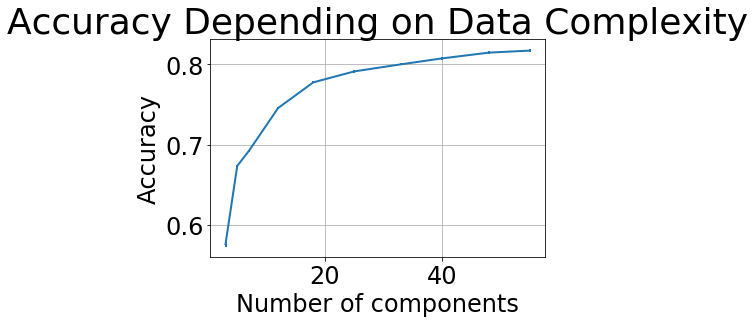

In [9]:
plt.errorbar(dim_list, mean, yerr=std)
plt.title("Accuracy Depending on Data Complexity")
plt.xlabel("Number of components")
plt.ylabel("Accuracy")
plt.grid(True)

std

Из графика видно, что для получения приемлемого качества модели достаточно 20-30 главных компонент (при этом модель обучается значительно быстрее чем при более точных решениях). Также стандартное отклонение, полученное в ходе обучения модели с заданными параметрами несколько раз, мало. Думаю, что это связано с тем, что PCA проецирует данные на подпространство меньшей размерности, уменьшая разницу между разными запусками [но это не точно:)]

#### Качество модели в зависимости от размера обучающей выборки

Рассмотрим как влияет размер обучающей выборки на качество обучаемой модели. Будем использовать PCA c 20 главными компонентами, усреднение по 10 запускам.

In [24]:
k = 10
obj_numbers = [200, 500, 1000, 2000, 5000, 10000, 20000]
results = np.empty((len(obj_numbers), k))
for n, obj_num in enumerate(obj_numbers):
    for i in tqdm(range(k), desc="%.0f train objects" % obj_num):
        res = step(fashion_mnist.load_data(), 20, obj_num)
        results[n, i] = res

mean = results.mean(axis=1)
std = results.std(axis=1)

20000 train objects: 100%|██████████| 10/10 [03:41<00:00, 22.10s/it]


array([0.02151682, 0.00810064, 0.00591463, 0.00396738, 0.00177282,
       0.00172977, 0.00131072])

/home/fox/cloud/miniconda/envs/mipt/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


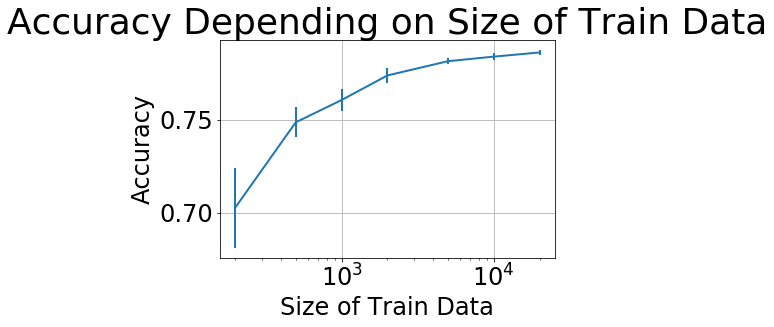

In [26]:
plt.errorbar(obj_numbers, mean, yerr=std)
plt.title("Accuracy Depending on Size of Train Data")
plt.xlabel("Size of Train Data")
plt.xscale("log")
plt.ylabel("Accuracy")
plt.grid(True)

std

Из графика видно, что если размера обучающей выборки более 5000, то качество модели растет не очень сильно. Возможно 5-10 тыс объектов будет достаточно для приемлемого уровня качества модели(при этом модель будет обучаться значительно быстрее чем при более точных решениях).